# Task 2 : Data Visualisation (15%)

## Streaming data visualisation

In [7]:
from time import sleep
from kafka3 import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import json
import datetime

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'Climate_Hotspot_Stream'
hostip = "192.168.100.7" 

<IPython.core.display.Javascript object>


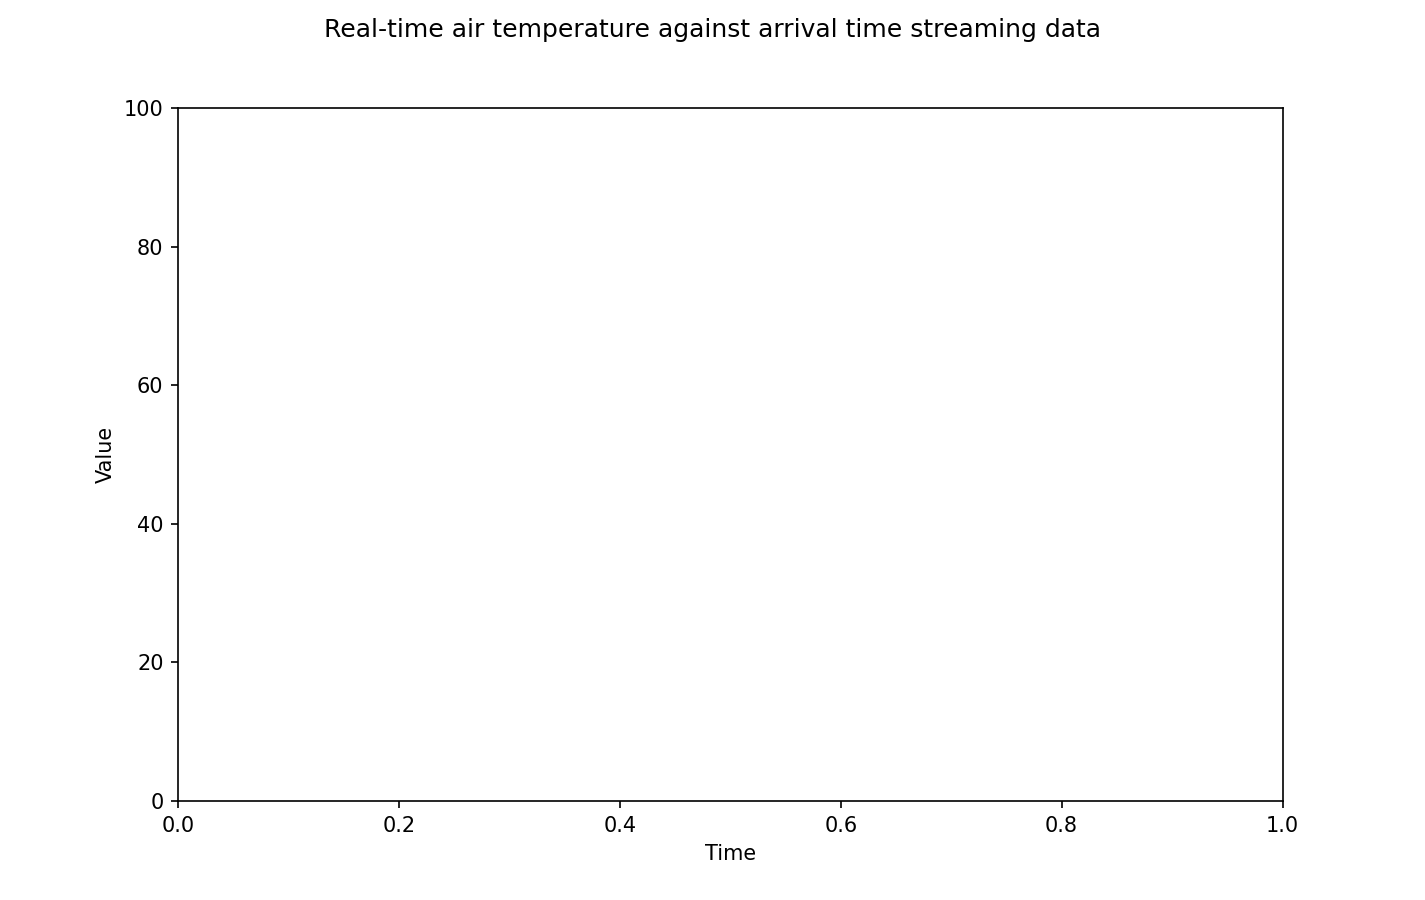

KeyboardInterrupt: 

In [8]:
def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=15000, # stop iteration if no message after 15 sec as there might be some delays
#                                    auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=[f'{hostip}:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time air temperature against arrival time streaming data') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_ylim(0,40) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # containers for max and min values and their corresponding timestamps
        
        for message in consumer:
            data = json.loads(message.value.decode('utf-8'))
            
            if data['producer']=='Climate':
                timestamp = datetime.datetime.now() # Accessing 'date' using key-based access
                temperature = int(data['air_temperature_celcius'])  # Accessing 'air_temperature_celcius' using key-based access
                x.append(timestamp)
                y.append(temperature)

                # we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Air Temperature')
                ax.set_ylim(0, 35)
                ax.set_yticks([0,5, 10, 15, 20, 25, 30, 35])
                annotate_max(x, y)
                annotate_min(x, y)
                fig.canvas.draw()
                x.pop(0)  # removing the item in the first position
                y.pop(0)
        
        plt.close('all')
    
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

Please click the 'Power off button' on the top right of the chart before running the following code.

## Static data visualisation (a)

In [ ]:
# Uncomment to install folium
#!pip3 install folium

In [9]:
import pymongo
import folium
from folium.plugins import MarkerCluster
from pymongo import MongoClient
client = MongoClient(hostip, 27017)

db = client["fit3182_asgn3"]
collection = db["stream_data"]

In [10]:
def plot_fire_records_by_hour():
    pipeline = [
        {
            '$unwind': '$fire_event'  # Unwind the fire_event array
        },
        {
            '$addFields': {
                'hour': {'$hour': {'$toDate': '$fire_event.datetime'}}
            }
        },
        {
            '$group': {
                '_id': '$hour',
                'count': {'$sum': 1}  # Count the number of fire events in each hour
            }
        },
        {
            '$sort': {
                '_id': 1
            }
        }
    ]

    result = collection.aggregate(pipeline)

    hours = []
    counts = []
    for doc in result:
        hours.append(doc['_id'])
        counts.append(doc['count'])

    fig = plt.figure(2) 
    plt.bar(hours, counts)
    tick_labels = [f'{h:02d}:00' for h in hours]
    plt.xticks(hours, tick_labels)
    plt.xlabel('Hour')
    plt.ylabel('Number of Fire Records')
    plt.title('Total Number of Fire Records by Hour')
    plt.show()


<IPython.core.display.Javascript object>


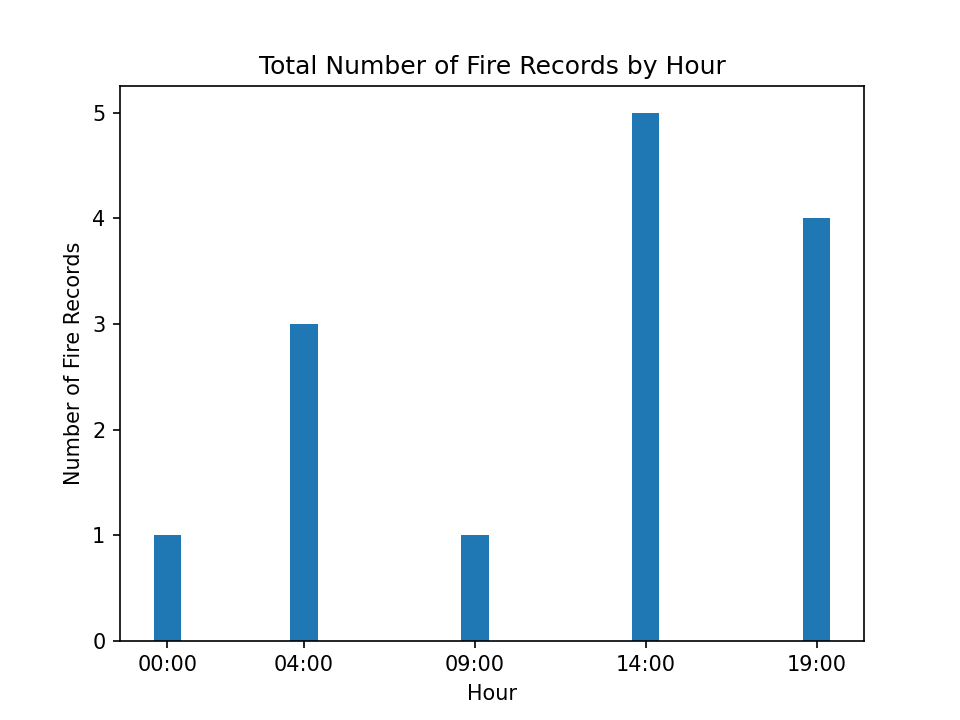

In [11]:
# Run the visualizations
plot_fire_records_by_hour()

## Static data visualisation (b)

In [5]:
def visualize_fire_locations():
    
    # Create a folium map centered on the first fire record
    first_fire_record = collection.find_one()
    lat = float(first_fire_record['latitude'])
    lon = float(first_fire_record['longitude'])
    fire_map = folium.Map(location=[lat, lon], zoom_start=8)

    # Query MongoDB to get fire records
    fire_records = collection.find()

    # Add markers for each fire record
    for record in fire_records:
        for fire_event in record['fire_event']:
            lat = float(fire_event['latitude'])
            lon = float(fire_event['longitude'])
            cause = fire_event['fire_cause']
            air_temperature = "{:.2f}".format(float(record['air_temperature_celcius']))
            surface_temperature = "{:.2f}".format(float(fire_event['surface_temperature_celcius']))
            relative_humidity = "{:.2f}".format(float(record['relative_humidity']))
            confidence = "{:.2f}".format(float(fire_event['confidence']))

            # Determine marker color based on fire_cause
            marker_color = 'blue' if cause == 'natural' else 'red'

            # Create marker with tooltip
            tooltip = f'Air Temperature: {air_temperature}°C<br>' \
                      f'Surface Temperature: {surface_temperature}°C<br>' \
                      f'Confidence: {confidence}'
            folium.Marker(location=[lat, lon], tooltip=tooltip, icon=folium.Icon(color=marker_color)).add_to(fire_map)

    # Display the map
    fire_map.save('fire_locations_map.html')
    return fire_map

In [6]:
visualize_fire_locations()